In [1]:
from sklearn.metrics import cohen_kappa_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
num_labels=10000
std_dev=1.0
steps=20
np.random.seed(42)

In [3]:
# Generate gold labels

def generate_gold_labels(num_labels):
    """Generates random gold labels uniformly distributed between 1 and 5."""
    # gold_labels = np.random.randint(1, 6, num_labels)
    gold_labels = [1,2,3,4,5]*(int(num_labels/5))
    print(f'Generated {len(gold_labels)} gold labels')
    return gold_labels

# Generate gold labels
gold_labels = generate_gold_labels(num_labels)
print("Gold labels:", gold_labels[:10])

Generated 10000 gold labels
Gold labels: [1, 2, 3, 4, 5, 1, 2, 3, 4, 5]


In [4]:
# Generate annotator labels

def generate_annotator_labels(gold_labels, num_labels, std_dev):
    """Generates annotator labels around gold labels with normal distribution noise."""
    annotator_labels = np.clip(np.round(gold_labels + np.random.normal(0, std_dev, num_labels)), 1, 5).astype(int)
    return annotator_labels

# Annotator A
annotator_a_labels = generate_annotator_labels(gold_labels, num_labels, std_dev)
print("Annotator A labels:", annotator_a_labels[:10])

# Annotator B
annotator_b_labels = generate_annotator_labels(gold_labels, num_labels, std_dev)
print("Annotator B labels:", annotator_b_labels[:10])

Annotator A labels: [1 2 4 5 5 1 4 4 4 5]
Annotator B labels: [1 2 2 4 5 1 3 2 3 5]


In [5]:
data = pd.DataFrame({
    'gold': gold_labels,
    'annotator_a': annotator_a_labels,
    'annotator_b': annotator_b_labels
})

data

,gold,annotator_a,annotator_b
0,1,1,1
1,2,2,2
2,3,4,2
3,4,5,4
4,5,5,5
...,...,...,...
9995,1,2,1
9996,2,1,3
9997,3,2,3
9998,4,4,5


In [6]:
# Kappa
kappa = cohen_kappa_score(annotator_a_labels, annotator_b_labels)
print(kappa)

0.2340221850343448


In [7]:
def sample_skewed_data(gold_labels, annotator_a_labels, annotator_b_labels, label_to_num_sample):
    """Samples data to create a skewed distribution based on label_to_num_sample dictionary."""
    data = pd.DataFrame({
        'gold': gold_labels,
        'annotator_a': annotator_a_labels,
        'annotator_b': annotator_b_labels
    })
    
    skewed_data = pd.DataFrame()
    for label, count in label_to_num_sample.items():
        sampled = data[data['gold'] == label].sample(n=count)
        skewed_data = pd.concat([skewed_data, sampled])
    
    return skewed_data

In [8]:


def get_kapp_values(label_order=[1,2,3,4,5]):
    kappa_values = []
    assert set(label_order) == set([1,2,3,4,5]), "label_order must contain all 5 labels"
    for step in range(0, steps):
        label_to_ratio = {label_order[i]: (1+0.1*i)**step for i in range(5)}
        total_ratio = sum(label_to_ratio.values())

        label_to_proportion = {label: ratio / total_ratio for label, ratio in label_to_ratio.items()}
        max_proportion = max(label_to_proportion.values())
        num_labels_for_each_label = num_labels/5
        label_to_num_sample = {}
        for label, ratio in label_to_ratio.items():
            label_to_num_sample[label] = int(num_labels_for_each_label * label_to_proportion[label] / max_proportion)

        skewed_sampled_data = sample_skewed_data(gold_labels, annotator_a_labels, annotator_b_labels, label_to_num_sample)
        
        # Calculate Cohen's kappa for the current distribution
        cohen_kappa = cohen_kappa_score(skewed_sampled_data['annotator_a'], skewed_sampled_data['annotator_b'])
        kappa_values.append(cohen_kappa)

        print(f'Step: {step:02d},\tNumber of samples for each label: {label_to_num_sample},\tKappa: {cohen_kappa}')

    return kappa_values

all_kappa_values = []
# try all combinations of label orders
import itertools
for label_order in itertools.permutations([1,2,3,4,5]):
    kappa_values = get_kapp_values(list(label_order))
    all_kappa_values.append(kappa_values)

# calculate average kappa values
average_kappa_values = np.mean(all_kappa_values, axis=0)

Step: 00,	Number of samples for each label: {1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 2000},	Kappa: 0.2340221850343448
Step: 01,	Number of samples for each label: {1: 1428, 2: 1571, 3: 1714, 4: 1857, 5: 2000},	Kappa: 0.23215265259737405
Step: 02,	Number of samples for each label: {1: 1020, 2: 1234, 3: 1469, 4: 1724, 5: 1999},	Kappa: 0.22969083400214463
Step: 03,	Number of samples for each label: {1: 728, 2: 970, 3: 1259, 4: 1601, 5: 1999},	Kappa: 0.21479613811106546
Step: 04,	Number of samples for each label: {1: 520, 2: 762, 3: 1079, 4: 1486, 5: 2000},	Kappa: 0.2132695494220581
Step: 05,	Number of samples for each label: {1: 371, 2: 598, 3: 925, 4: 1380, 5: 1999},	Kappa: 0.20516059336374826
Step: 06,	Number of samples for each label: {1: 265, 2: 470, 3: 793, 4: 1282, 5: 2000},	Kappa: 0.18997032936206615
Step: 07,	Number of samples for each label: {1: 189, 2: 369, 3: 679, 4: 1190, 5: 2000},	Kappa: 0.18701664772828752
Step: 08,	Number of samples for each label: {1: 135, 2: 290, 3: 582, 4:

In [9]:

def plot_kappa(kappa_values, steps):
    """Plots the Cohen's kappa values across the transition from uniform to skewed distribution."""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, steps + 1), kappa_values, marker='o', linestyle='-', color='blue')
    plt.title("Cohen's Kappa Across Transition from Uniform to Skewed Distribution")
    plt.xlabel("Step (Transition to Skewed Distribution)")
    plt.ylabel("Cohen's Kappa")
    plt.grid(True)
    plt.show()


# plot_kappa(kappa_values, steps)

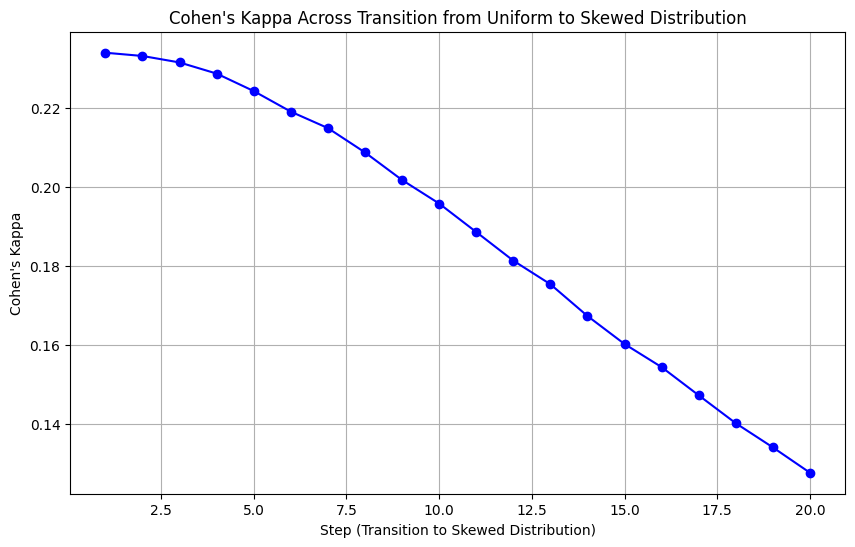

In [10]:
plot_kappa(average_kappa_values, steps)